In [1]:
import pandas as pd

import seaborn as sns

sns.set_context("talk")
import matplotlib.pyplot as plt
import statsmodels

import statsmodels.formula.api as smf
import numpy as np

plt.style.use("ggplot")

In [2]:
data=pd.read_csv('clean_data/final_dataset.csv')
data[['income_census','pop_census']]=np.log(data[['income_census','pop_census']])

In [3]:
data.columns
y = "mortality_alcohol"
x = [
    "pop_census",
    "nhwrate",
    "blkrate",
    "asianrate",
    "hisprate",
    "nativerate",
    "state_mormon",
    "altitude",
    "mormon",
    "income_census"
]

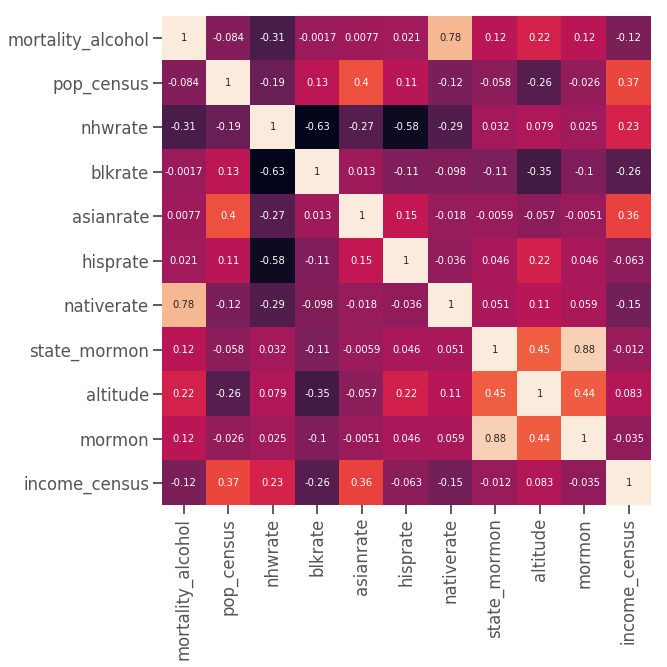

In [4]:
plt.figure(figsize=(9,9))
sns.heatmap(data[[y]+x].corr(),annot=True,square=True,cbar=False)

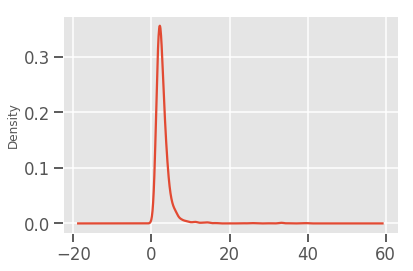

In [5]:
#lognormal
data['mortality_alcohol'].plot.kde()

In [6]:
data.mortality_alcohol.describe()

count    3126.000000
mean        2.973385
std         2.657833
min         0.710000
25%         1.830000
50%         2.430000
75%         3.317500
max        39.680000
Name: mortality_alcohol, dtype: float64

In [7]:
import statsmodels.api as sm


def regress(
    x,
    y,
    model="ols",
    plot=False,
    summary=False,
    show_nonsignificant=False,
    data=data,
    log=False,
):
    # Weighted regression due to different pop size in each county. Lower pops will be noisier.
    if log:
        expr = f"np.log({y})~" + "+".join(x)
        logiflog = np.log
    else:
        expr = f"({y})~" + "+".join(x)
        logiflog = lambda x: x
    if model == "glm":
        ret = smf.glm(
            expr,
            data=data,
            family=sm.families.Gaussian(link=sm.families.links.log()),
            var_weights=data.pop_census,
        ).fit()
    elif model == "wls":
        ret = smf.ols(expr, data=data).fit()
    else:
        ret = smf.wls(expr, data=data, weights=data["pop_census"]).fit()
    if summary:
        display(ret.summary())
    if plot:
        if model == "glm":
            pred = logiflog(ret.predict(data[x]).squeeze())
        else:
            pred = logiflog(ret.predict(data[x]).squeeze())
        display(plt.scatter(data[y], pred))
        max_y = max(data[y])
        min_y = min(data[y])
        plt.plot([min_y, max_y], [min_y, max_y], c="blue")
    df = pd.concat([ret.params, ret.pvalues], axis=1)

    df.columns = ["coefficients", "pvalue"]
    df["pvalue"] = df["pvalue"].round(3)
    df["pvalue"] = np.where(
        df.pvalue < 0.05, df.pvalue.astype(str) + "*", df.pvalue.astype(str)
    )
    if not show_nonsignificant:
        df = df[df.pvalue.str.contains("\*")]

    mean_frame = data[x].mean().to_frame().T
    if 'state' in x:
        mean_frame['state']='Utah'
    mean_predicted = ret.predict(mean_frame).values
    display(f"Baseline value: {np.round(mean_predicted,2).squeeze()}")

    for var in df.index:
        if var != "Intercept" and "state[" not in var:
            df.loc[var, "var_max_value"] = data[var].max()
            df.loc[var, "var_mean_value"] = data[var].mean()
            df.loc[var, "effect_mean_to_max"] = (
                ret.predict(mean_frame.assign(**{var: data[var].max()})).values
                - mean_predicted
            )
    # df["effect_pc"] = 100 * (df.effect_mean_to_max) / mean_predicted
    df = df.round(3)

    return df, ret


t, mod = regress(x, y, model="glm", log=False)
t

'Baseline value: 2.79'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,2.494,0.0*,NaN,NaN,NaN
pop_census,-0.015,0.017*,16.078,10.225,-0.232
nhwrate,-3.569,0.0*,1.000,0.788,-1.482
blkrate,-2.758,0.0*,0.861,0.089,-2.463
asianrate,-5.715,0.0*,0.522,0.011,-2.644
hisprate,-3.205,0.0*,0.983,0.078,-2.641
altitude,0.000,0.0*,4008.285,424.280,3.724
income_census,0.196,0.0*,11.073,9.996,0.658


In [8]:
# #Keep state as per BIC and AIC
# df,mod=regress(x,y2,model='glm')
# df
# #???? (weird numerical error)

In [9]:
df,mod=regress(x,y,model='ols',)
df

'Baseline value: 2.97'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
pop_census,0.079,0.001*,16.078,10.225,0.461
blkrate,4.219,0.01*,0.861,0.089,3.260
nativerate,30.734,0.0*,0.889,0.017,26.791
altitude,0.001,0.0*,4008.285,424.280,3.858


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_alcohol   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     566.8
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:06:41   Log-Likelihood:                -5870.5
No. Observations:                3126   AIC:                         1.176e+04
Df Residuals:                    3115   BIC:                         1.183e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5754      2.247      0.256      0.798      -3.830       4.980
pop_census        0.0656      0.024      2.706      0.007       0.018       0.113
nhwrate           0.3248      1.722      0.189      0.850      -3.051       3.701
blkrate           2.8376      1.714      1.656      0.098      -0.522       6.198
asianrate         1.7740      2.514      0.706      0.480      -3.154       6.702
hisprate          0.6631      1.719      0.386      0.700      -2.707       4.033
nativerate       29.5099      1.890     15.612      0.000      25.804      33.216
state_mormon      1.0183      0.838      1.216      0.224      -0.624       2.661
altitude          0.0010   7.43e-05     13.560      0.000       0.001       0.001
mormon           -0.0006      0.001     -0.785      0.432      -0.002       0.001
income_census     0.0208      0.161      0.129      0.897      -0.294       0.336
==============================================================================
Omnibus:                     2614.544   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           380767.713
Skew:                           3.264   Prob(JB):                         0.00
Kurtosis:                      56.673   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: 2.97'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
pop_census,0.066,0.007*,16.078,10.225,0.384
nativerate,29.510,0.0*,0.889,0.017,25.723
altitude,0.001,0.0*,4008.285,424.280,3.612


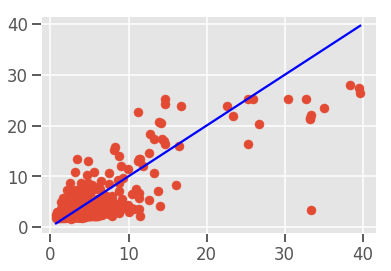

In [10]:
#Not much difference from plain OLS
df,mod=regress(x,y,model='wls',plot=True,summary=True)
df

In [11]:
target = data.query('county=="Salt Lake"')[x]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target).values[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": mod.predict(no_mormons).values[0],
        "no_mormons-predicted": mod.predict(no_mormons).values[0] - mod.predict(target).values[0],
    }
)

predicted               4.076106
baseline                5.470000
no_mormons              4.405888
no_mormons-predicted    0.329782
dtype: float64

# Effect of mormon
After controlling for income, the effect of mormonism is similar to the effect of everything else: tiny. Full mormonisation would yield negligible gains.

But what if? Mormon->Income?

'Baseline value: 10.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,9.767,0.0*,NaN,NaN,NaN
mormon,-0.000,0.002*,1007.860,21.801,-0.127
nhwrate,0.275,0.0*,1.000,0.788,0.058
blkrate,-0.168,0.0*,0.861,0.089,-0.130
asianrate,3.753,0.0*,0.522,0.011,1.918
nativerate,-0.278,0.0*,0.889,0.017,-0.242


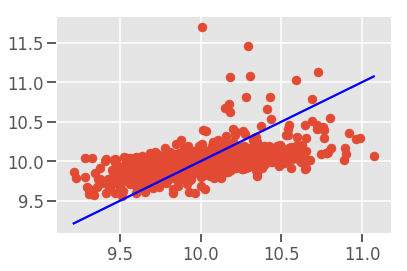

In [12]:
df, mod = regress(
    ["mormon", "nhwrate", "blkrate", "asianrate", "nativerate"],
    "income_census",
    plot=True,
)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_alcohol   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     566.8
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:06:42   Log-Likelihood:                -5870.5
No. Observations:                3126   AIC:                         1.176e+04
Df Residuals:                    3115   BIC:                         1.183e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5754      2.247      0.256      0.798      -3.830       4.980
pop_census        0.0656      0.024      2.706      0.007       0.018       0.113
nhwrate           0.3248      1.722      0.189      0.850      -3.051       3.701
blkrate           2.8376      1.714      1.656      0.098      -0.522       6.198
asianrate         1.7740      2.514      0.706      0.480      -3.154       6.702
hisprate          0.6631      1.719      0.386      0.700      -2.707       4.033
nativerate       29.5099      1.890     15.612      0.000      25.804      33.216
state_mormon      1.0183      0.838      1.216      0.224      -0.624       2.661
altitude          0.0010   7.43e-05     13.560      0.000       0.001       0.001
mormon           -0.0006      0.001     -0.785      0.432      -0.002       0.001
income_census     0.0208      0.161      0.129      0.897      -0.294       0.336
==============================================================================
Omnibus:                     2614.544   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           380767.713
Skew:                           3.264   Prob(JB):                         0.00
Kurtosis:                      56.673   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: 2.97'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
pop_census,0.066,0.007*,16.078,10.225,0.384
nativerate,29.510,0.0*,0.889,0.017,25.723
altitude,0.001,0.0*,4008.285,424.280,3.612


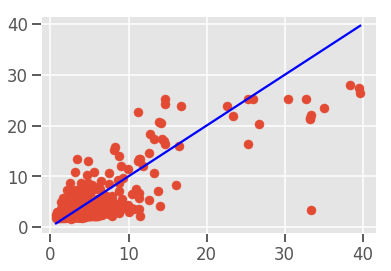

In [13]:
x2=x+['state']
#Keep state as per BIC and AIC
df,mod=regress(x,y,model='wls',plot=True,summary=True)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_alcohol   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     152.7
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:06:42   Log-Likelihood:                -5348.5
No. Observations:                3126   AIC:                         1.082e+04
Df Residuals:                    3066   BIC:                         1.118e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.3235      2.678      0.868      0.386      -2.927       7.574
state[T.Alaska]                   8.1996      0.390     21.034      0.000       7.435       8.964
state[T.Arizona]                  1.7228      0.408      4.217      0.000       0.922       2.524
state[T.Arkansas]                 0.4225      0.230      1.839      0.066      -0.028       0.873
state[T.California]               1.6654      0.271      6.144      0.000       1.134       2.197
state[T.Colorado]                 2.0063      0.305      6.576      0.000       1.408       2.604
state[T.Connecticut]              0.8172      0.514      1.589      0.112      -0.191       1.825
state[T.Delaware]                 1.5502      0.800      1.938      0.053      -0.018       3.119
state[T.District of Columbia]     4.9036      1.369      3.581      0.000       2.219       7.588
state[T.Florida]                  1.8047      0.239      7.553      0.000       1.336       2.273
state[T.Georgia]                  1.3398      0.197      6.786      0.000       0.953       1.727
state[T.Hawaii]                   2.0654      1.001      2.064      0.039       0.104       4.027
state[T.Idaho]                    0.8149      0.281      2.900      0.004       0.264       1.366
state[T.Illinois]                 0.2487      0.222      1.121      0.262      -0.186       0.684
state[T.Indiana]                  0.6423      0.228      2.817      0.005       0.195       1.089
state[T.Iowa]                     0.9226      0.225      4.095      0.000       0.481       1.364
state[T.Kansas]                   1.5448      0.226      6.850      0.000       1.103       1.987
state[T.Kentucky]                 0.8421      0.216      3.899      0.000       0.419       1.265
state[T.Louisiana]               -0.2361      0.237     -0.996      0.319      -0.701       0.229
state[T.Maine]                    1.8775      0.383      4.905      0.000       1.127       2.628
state[T.Maryland]                 0.3948      0.328      1.203      0.229      -0.248       1.038
state[T.Massachusetts]            2.3200      0.407      5.693      0.000       1.521       3.119
state[T.Michigan]                 1.1189      0.231      4.846      0.000       0.666       1.572
state[T.Minnesota]                1.3082      0.231      5.652      0.000       0.854       1.762
state[T.Mississippi]              0.0651      0.225      0.289      0.773      -0.377       0.507
state[T.Missouri]                 0.7038      0.217      3.243      0.001       0.278       1.129
state[T.Montana]                  2.0698      0.265      7.803      0.000       1.550       2.590
state[T.Nebraska]                 0.5604      0.232      2.414      0.016       0.105       1.016
state[T.Nevada]                   3.1167     

'Baseline value: 2.67'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
state[T.Alaska],8.200,0.0*,NaN,NaN,NaN
state[T.Arizona],1.723,0.0*,NaN,NaN,NaN
state[T.California],1.665,0.0*,NaN,NaN,NaN
state[T.Colorado],2.006,0.0*,NaN,NaN,NaN
state[T.District of Columbia],4.904,0.0*,NaN,NaN,NaN
state[T.Florida],1.805,0.0*,NaN,NaN,NaN
state[T.Georgia],1.340,0.0*,NaN,NaN,NaN
state[T.Hawaii],2.065,0.039*,NaN,NaN,NaN
state[T.Idaho],0.815,0.004*,NaN,NaN,NaN
state[T.Indiana],0.642,0.005*,NaN,NaN,NaN


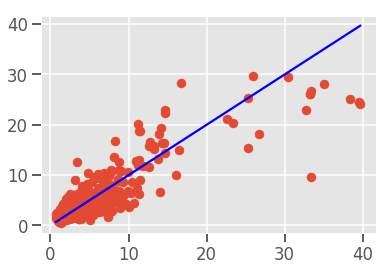

In [14]:
df,mod=regress(x2,y,model='wls',plot=True,summary=True)
df

In [15]:
target = data.query('county=="Salt Lake"')[x2]
no_mormons = target.assign(mormon=target.mormon*0.9)
pd.Series(
    {
        "predicted": mod.predict(target).values[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": mod.predict(no_mormons).values[0],
        "no_mormons-predicted": mod.predict(no_mormons).values[0]
        - mod.predict(target).values[0],
    }
)

predicted               3.972844
baseline                5.470000
no_mormons              3.995123
no_mormons-predicted    0.022278
dtype: float64

Final prediction from linear models: Full 1000->0 demormonisation would lead to a rise in alcohol-related death of 0.22pp.

But large difference between predicted value and real value.

# Let's try catboost

In [16]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMRegressor, Dataset
from lightgbm import plot_importance

ITERATIONS = 100


def get_bayes_tuner(cat_feat=[]):
    search_space = {
        "num_leaves": (10, 40),
        "min_child_samples": (5, 50),
        "learning_rate": (0.01, 0.5, "uniform"),
        "n_estimators": (10, 500),
        "min_split_gain": (0.0, 1.0, "uniform"),
        "colsample_bytree": (0.5, 0.8, 1),
    }
    return BayesSearchCV(
        estimator=LGBMRegressor(n_jobs=6, weight_column="pop_census"),
        search_spaces=search_space,
        cv=KFold(n_splits=20, shuffle=True, random_state=42),
        n_jobs=2,
        n_iter=ITERATIONS,
        verbose=3,
        refit=True,
        random_state=42,
        scoring="r2",
        fit_params={"categorical_feature": cat_feat},
    )

In [17]:
data['state_factor'],factor_array=pd.factorize(data.state)

In [18]:
x3=x2[::1]
x3.remove('state')
x3.append('state_factor')
x3.append('income_census')

In [19]:
cat_pos = np.where(data[x3].dtypes == int)[0].tolist()

bayes_tuner = get_bayes_tuner(cat_pos)
cat = bayes_tuner.fit(data[x3], data[y])

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   11.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   11.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.6s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


In [29]:
cat.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'min_child_samples': 5,
 'min_split_gain': 0.9622919980143133,
 'n_estimators': 463,
 'num_leaves': 40}

In [20]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score',ascending=False)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_split_gain,param_n_estimators,param_num_leaves,params
81,0.428158,0.671534,0.568883,0.756839,0.483621,0.620940,0.821386,0.659768,0.437996,0.886760,...,0.050268,0.005960,0.000925,0.5,0.010000,5,0.962292,463,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
77,0.435063,0.667117,0.571319,0.755675,0.486288,0.616791,0.819052,0.656458,0.442110,0.886842,...,0.221298,0.010429,0.007525,0.5,0.010000,5,0.736197,462,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
78,0.429309,0.662922,0.563952,0.749767,0.491147,0.620427,0.816844,0.668043,0.438635,0.885561,...,0.453446,0.010326,0.005771,0.5,0.010000,5,0.480719,474,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
60,0.431250,0.665327,0.578107,0.755509,0.486232,0.619545,0.819549,0.666004,0.438366,0.883113,...,0.089333,0.005575,0.000932,0.5,0.010000,5,0.274476,432,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
58,0.433651,0.670352,0.567368,0.762891,0.483806,0.622436,0.819276,0.652254,0.436629,0.885347,...,0.143999,0.006855,0.005458,0.5,0.010000,5,0.633184,436,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
49,0.431353,0.667330,0.575254,0.749857,0.483517,0.611556,0.826115,0.647909,0.440973,0.887495,...,0.075815,0.006976,0.006218,0.5,0.010000,5,1.000000,500,30,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
71,0.429699,0.658542,0.564081,0.749316,0.488721,0.622846,0.820666,0.659633,0.441630,0.884194,...,0.115392,0.006088,0.001262,0.5,0.010000,5,0.578375,471,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
66,0.427746,0.661577,0.573874,0.759906,0.477604,0.622131,0.821049,0.660801,0.437741,0.883962,...,0.027146,0.005841,0.001097,0.5,0.010000,5,1.000000,437,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
68,0.427410,0.661430,0.573612,0.759922,0.477910,0.621961,0.821077,0.660729,0.437463,0.883978,...,0.273139,0.008810,0.007441,0.5,0.010000,5,1.000000,436,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
73,0.429154,0.669450,0.560822,0.756875,0.485888,0.623341,0.816832,0.653320,0.440901,0.886423,...,0.562576,0.008141,0.004397,0.5,0.010000,5,0.636502,479,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."


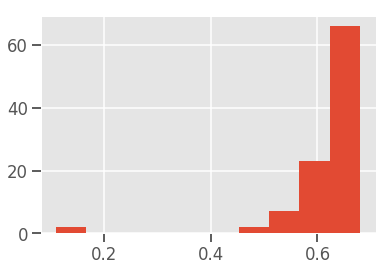

In [21]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score').mean_test_score.hist()

Catboost is a nonlinear model, so we lose explainability. Feature importances in tree models are commonly used to try to interpret them, but those may be biased by multicollinearity. Let's try to see what we get from them first:

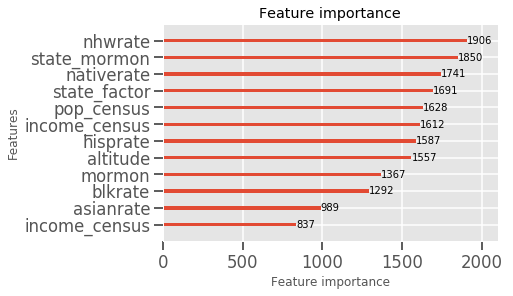

In [22]:
plot_importance(cat.best_estimator_)

Again, mormon comes as relatively not important

### Explanation with SHAP

These feature importances may be fake news because of multicollinearity issues, so we turn to SHAP to see what features drive this model.

[SHAP](https://arxiv.org/pdf/1705.07874.pdf) produces a score for each pair of (feature,sample), indicating how much that feature contributed in that particular case. In effect SHAP is solving a credit assignment problem.

Unlike with the coefficients in OLS, here we have scores per pair of features, which make it more important to visualise what is going on on a case by case basis to see if trends emerge

In [23]:
import shap
shap.initjs()


In [30]:
explainer = shap.TreeExplainer(cat.best_estimator_,
                               feature_dependence="independent",
                              data=data[x3])
shap_sample=data[x３].sample(500)
shaps = explainer.shap_values(shap_sample)

100%|===================| 499/500 [04:08<00:00]        

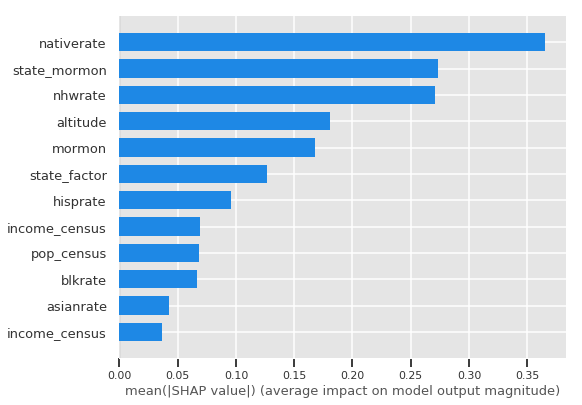

In [26]:
shap.summary_plot(shaps,data[x3], plot_type="bar")

Also in CatBoost, mormons are not a significant variable

AssertionError: Feature and SHAP matrices must have the same number of rows!

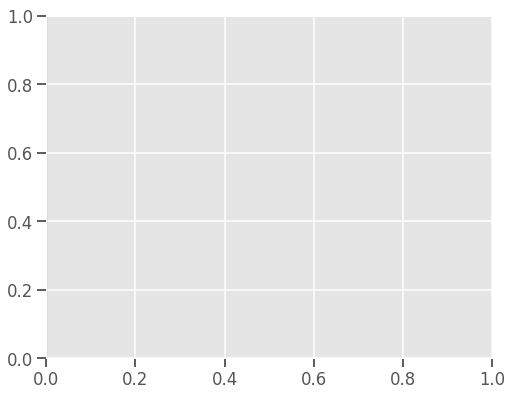

In [27]:
# This plot measures the impact of a variable on poverty. Each point is a particular county.
# The y-size of each row represents the density of points at that particular point
# High SHAP values mean in that case the variable in that case contributed to a higher poverty rate
# The sense in which it contributed can be glanced from the colorbar
# For example, the blue points in income_census mean that when income was low, the SHAP value was high (higher poverty)
# Positive values mean that in that part
shap.summary_plot(shaps,data[x3])

In [ ]:
shap.dependence_plot("mormon", shaps,data[x3],show=False)
plt.tight_layout()
plt.savefig('figures/alcohol_shap.png')

In [ ]:
shap.dependence_plot("pop_census", shaps,data[x3],show=False)
plt.tight_layout()
plt.savefig('figures/alcohol_pop.png')

In [ ]:
shap.dependence_plot("income_census", shaps,data[x3])

In [ ]:
#Salt Lake
shap.force_plot(explainer.expected_value,shaps[2778,:],data[x3].loc[2778,:])

In [ ]:
shap.force_plot(explainer.expected_value,shaps[217,:],data[x3].loc[217,:])

In [ ]:
data.query('county=="San Francisco"')

In [ ]:
target = data.query('county=="Salt Lake"')[x3]
no_mormons = target.assign(mormon=target.mormon*0.9)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": cat.predict(no_mormons)[0],
         "diff":-cat.predict(target)[0]+cat.predict(no_mormons)[0]
    }
)

In [ ]:
target = data.query('county=="Utah"')[x3]
no_mormons = target.assign(mormon=target.mormon*0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].loc[target.index].values[0],
        "no_mormons": cat.predict(no_mormons)[0],
         "diff":-cat.predict(target)[0]+cat.predict(no_mormons)[0]
    }
)

In [ ]:
data.index

With catboost the effect is reversed: Demormonisation would reduce alcoholism-related deaths by 0.36 pp. But there is some difference between the baseline (real) and predicted values.

In [ ]:
target = data.query('county=="Salt Lake"')[x3]
effects=[]
for i in np.arange(0,1000,100):
    counterfactual = target.assign(mormon=i)
    t=pd.Series(
        {
            "predicted": cat.predict(target)[0],
            "baseline": data[y].iloc[target.index].values[0],
            "counterf": cat.predict(counterfactual)[0],
             "diff":-cat.predict(target)[0]+cat.predict(counterfactual)[0]
        }
    )
    effects.append(t['diff'])
plt.scatter(np.arange(0,1000,100),effects)

What would happen if SLC had a substantial native population?

In [ ]:
target = data.query('county=="Salt Lake"')[x3]
counterfactual = target.assign(nhwrate=0,hisprate=0,blkrate=0,nativerate=1,asianrate=0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "counterf": cat.predict(counterfactual)[0],
         "diff":-cat.predict(target)[0]+cat.predict(counterfactual)[0]
    }
)

In [ ]:
target = data.query('county=="Utah"')[x3]
effects=[]
for i in np.arange(0,1000,100):
    counterfactual = target.assign(mormon=i)
    t=pd.Series(
        {
            "predicted": cat.predict(target)[0],
            "baseline": data[y].iloc[target.index].values[0],
            "counterf": cat.predict(counterfactual)[0],
             "diff":-cat.predict(target)[0]+cat.predict(counterfactual)[0]
        }
    )
    effects.append(t['diff'])
    
    

In [ ]:
plt.scatter(np.arange(0,1000,100),effects)

In [ ]:
target

In [ ]:
#Utah County
shap.force_plot(explainer.expected_value,shaps[2785,:],data[x3].loc[2785,:])

In that case alcoholism would increase by far more.